# The Single Neuron Logistic Regression Model

## Part 1: Set up

First we import our packages and read in our dataframe. There are 3 species in the "penguins" dataset. Previously, when creating the perceptron, we tried to use bill length and bill depth to classify specimens as either Adelie or Chinstrap. Below we can see that data (not linearly separable), along with an example of linearly separable data, using the Adelie and Gentoo species.

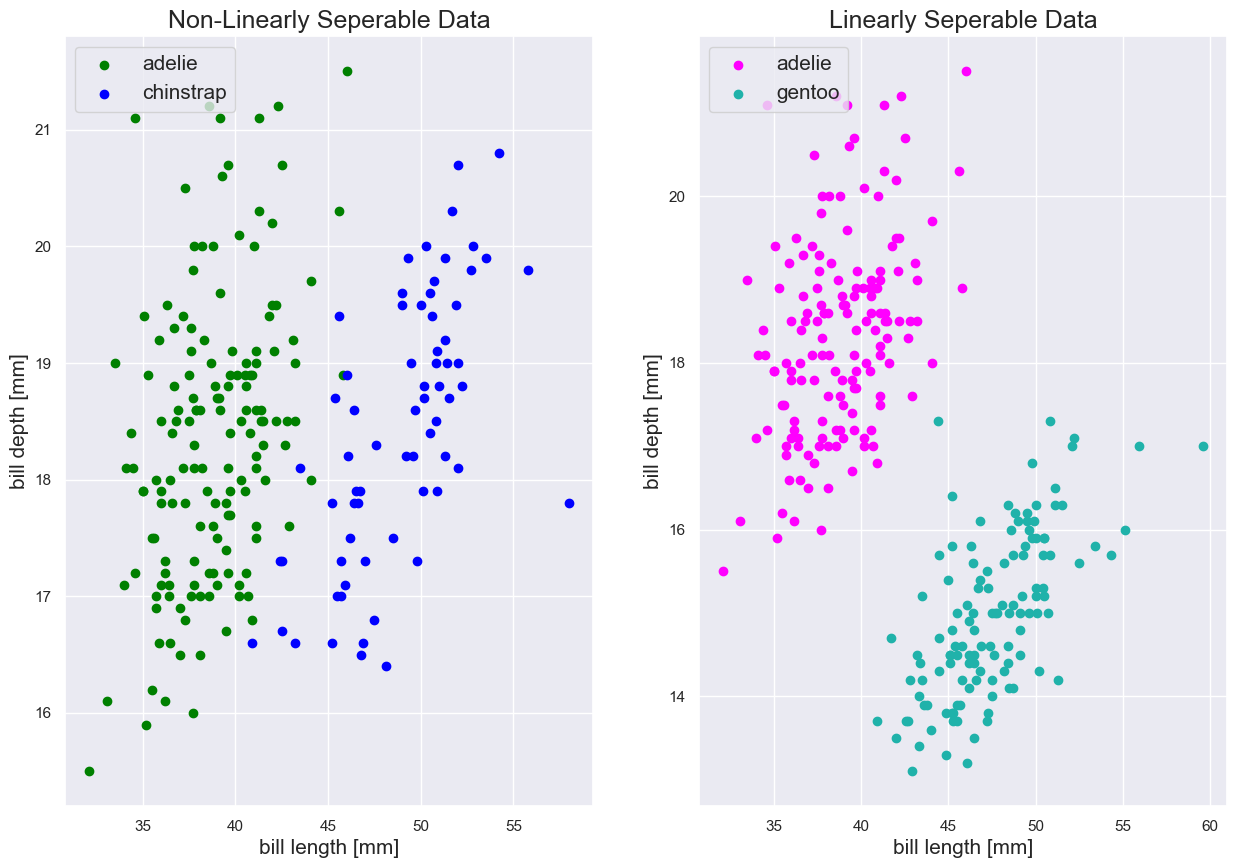

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

sns.set_theme()

df = sns.load_dataset("penguins")

# cleaning data, removing row with NaN values
df = df.drop(3)

adelie = df[df.species == "Adelie"]
chinstrap = df[df.species == "Chinstrap"]
gentoo = df[df.species == "Gentoo"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(adelie.bill_length_mm, 
            adelie.bill_depth_mm, 
            color = "green", 
            label = "adelie")
ax1.scatter(chinstrap.bill_length_mm, 
            chinstrap.bill_depth_mm, 
            color = "blue", 
            label = "chinstrap")
ax1.set_xlabel("bill length [mm]", fontsize = 15)
ax1.set_ylabel("bill depth [mm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


ax2.scatter(adelie.bill_length_mm, 
            adelie.bill_depth_mm, 
            color = "magenta", 
            label = "adelie")
ax2.scatter(gentoo.bill_length_mm, 
            gentoo.bill_depth_mm, 
            color = "lightseagreen", 
            label = "gentoo")
ax2.set_xlabel("bill length [mm]", fontsize = 15)
ax2.set_ylabel("bill depth [mm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
ax2.set_title("Linearly Seperable Data", fontsize = 18)
plt.show()

Now we will focus on only examining bill length. The following plot uses a single vertical line to create a rough division in the data. In essence, most of the adelie penguins fall to the left and most chinstrap penguins fall to the right. As a rough estimate, I placed the dividing line at 44.5 mm, though later we will use the logistic model to predict this value. For now, doing this allows us to see that if a specimen falls to the left of the line it has a high **probability** of being an adelie penguin and vice versa.

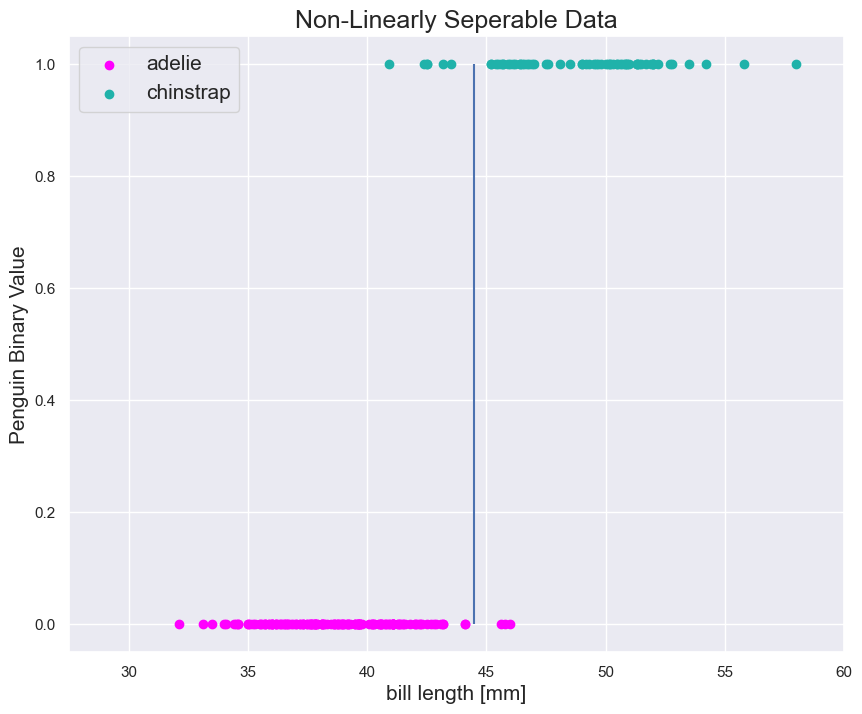

In [127]:
plt.figure(figsize = (10, 8))
plt.xlim((27.5, 60 ))

adelie_len = len(adelie.bill_length_mm)
chinstrap_len = len(chinstrap.bill_length_mm)

plt.scatter(adelie.bill_length_mm, 
            np.zeros(adelie_len), 
            color = "magenta", 
            label = "adelie")
plt.scatter(chinstrap.bill_length_mm, 
            np.ones(chinstrap_len), 
            color = "lightseagreen", 
            label = "chinstrap")
plt.vlines(44.5, 0.0, 1.0)
plt.xlabel("bill length [mm]", fontsize = 15)
plt.ylabel("Penguin Binary Value", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

## Part 2: Designing the model

One main feature of the logistic model is its sigmoid activation function, $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

We will compare a plot of the sigmoid function with a plot of our 'binary' data. As shown below, the preliminary result appears promising, as the tails of the sigmoid function flatten out in alignment with the clustering of each species' data points.

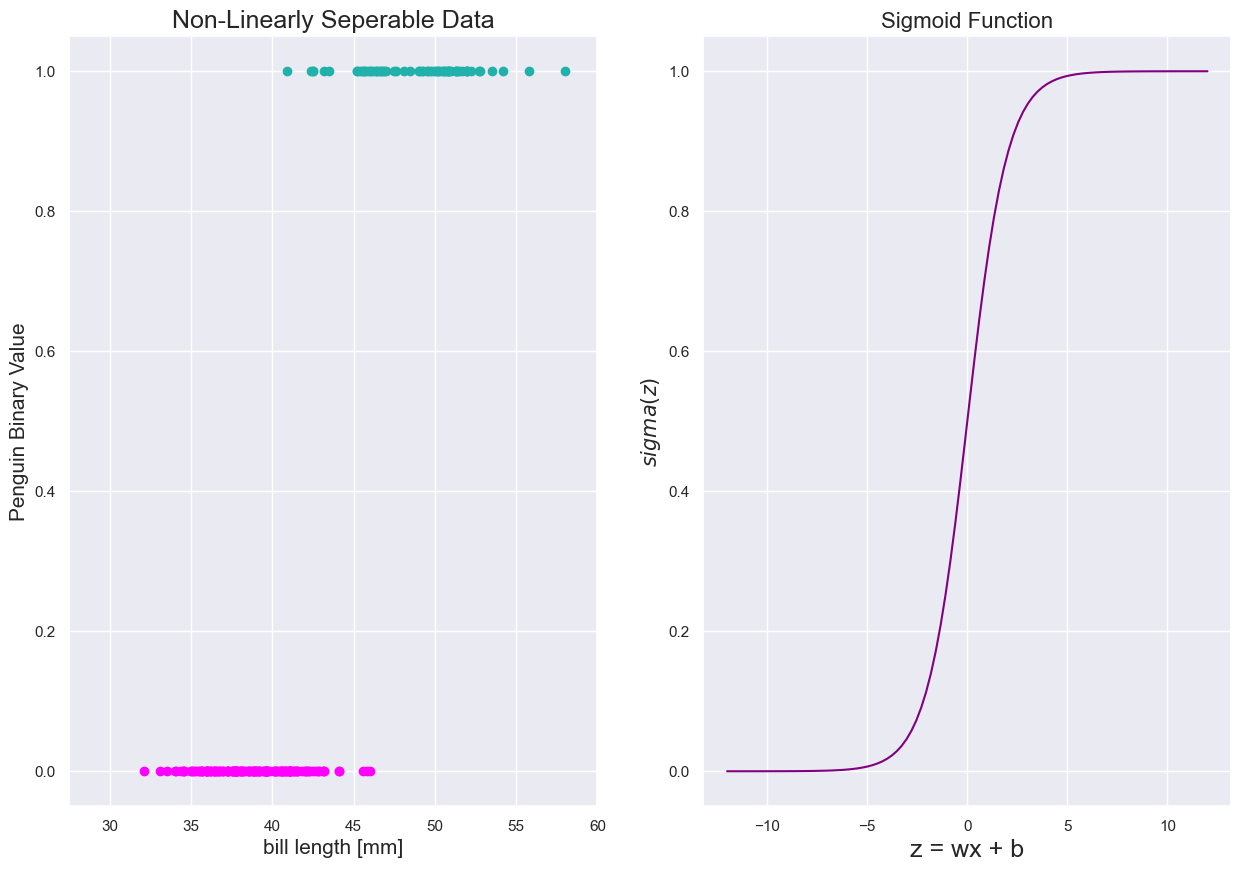

In [128]:
def sigmoid_fn(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_xlim((27.5, 60 ))
ax1.scatter(adelie.bill_length_mm, 
            np.zeros(adelie_len), 
            color = "magenta", 
            label = "versicolor")
ax1.scatter(chinstrap.bill_length_mm, 
            np.ones(chinstrap_len), 
            color = "lightseagreen", 
            label = "chinstrap")
ax1.set_xlabel("bill length [mm]", fontsize = 15)
ax1.set_ylabel("Penguin Binary Value", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, 
        sigmoid_fn(domain), 
        color = "purple", 
        label = "sigma(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("Sigmoid Function", fontsize = 16)
plt.show()

We will use the same Neuron class as before, with a few new methods for plotting. These methods help improve efficiency and reduce time spent wirting redundant code. Additionally, we now initialize an instance of our class with a cost function, allowing us to include the model's particular cost function as one of its attributes.

In [69]:
class Neuron(object):
    """
    A class representing a single artificial neuron for binary or regression tasks.

    ...

    Attributes
    ----------
    activation_fn : callable
        The activation function applied to the weighted input (e.g., sigmoid, identity, tanh).

    cost_fn: callable
        The cost function applied to the prediction and the observed value.

    weights_ : numpy.ndarray
        Weight vector including the bias term (last entry). Initialized during training.

    loss_history_ : list
        Stores the mean squared error after each training epoch.

    Methods
    -------
    fit(self, X, y, learning_rate=0.005, epochs=50)
        Trains the neuron using stochastic gradient descent (SGD) on input data X and labels y.

    predict(self, X)
        Computes the neuron's output for the given input(s) X using the learned weights and activation.
    """

    def __init__(self, activation_fn, cost_fn):
        self.activation_fn = activation_fn
        self.cost_fn = cost_fn

    def fit(self, X, y, learning_rate=0.005, epochs=50):
        self.weights_ = np.random.rand(X.shape[1] + 1)  # Last element is bias
        self.loss_history_ = []
        n_samples = X.shape[0]

        for _ in range(epochs):
            total_error = 0
            for x_i, y_i in zip(X, y):
                y_hat = self.predict(x_i)
                error = y_hat - y_i
                self.weights_[:-1] -= learning_rate * error * x_i  # update weights
                self.weights_[-1]  -= learning_rate * error         # update bias
                total_error += 0.5 * error**2
            self.loss_history_.append(total_error / n_samples)
        return self
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights_[:-1]) + self.weights_[-1]
        return self.activation_fn(linear_output)
    
    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.loss_history_) + 1), 
                self.loss_history_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

## Part 3: Training & Analysis

Now we will instantiate and train our model using the sigmoid activation function, defined below, and the binary cross entropy loss function.

In [129]:
def bin_ent_loss(y_pred, y):
    return - y*np.log(y_pred) - (1 - y)*np.log(1 - y_pred)

node = Neuron(sigmoid_fn, bin_ent_loss)

# Ensures we only use data from rows that are either Adelie or Chinstrap
X = df.iloc[:220].bill_length_mm.values
X = X.reshape(-1, 1)

# Scaling the X data, to make sure values do not shoot off to infinity, while maintaining data shape
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Assigns Chinstrap penguins a value of 1, Adelie a value of 0
y = np.where(df.iloc[:220].species == "Adelie", 0, 1)

node.fit(X_scaled, y, learning_rate = 0.001, epochs = 500)

In the plot below, we can observe how the cost function rapidly decreases over the course of the training. This shape makes sense, as the model instantiates with random weights, but would quickly learn to become more accurate (hense the steep decline), and then spend the remaining epochs honing in on minor adjustments to the weights and bias (the slow plateau).

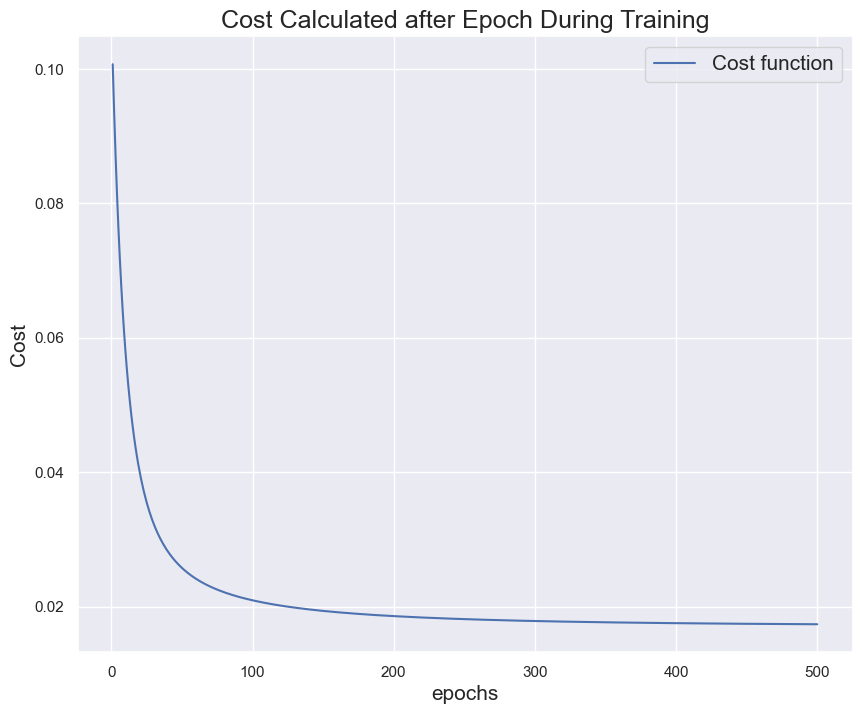

In [130]:
node.plot_cost_function()

---
Next, we will look at our approximation of the target function. As shown below, the curve is fairly aligned with the data points and seems to be a good indicator of whether a penguin is Adelie or Chinstrap.

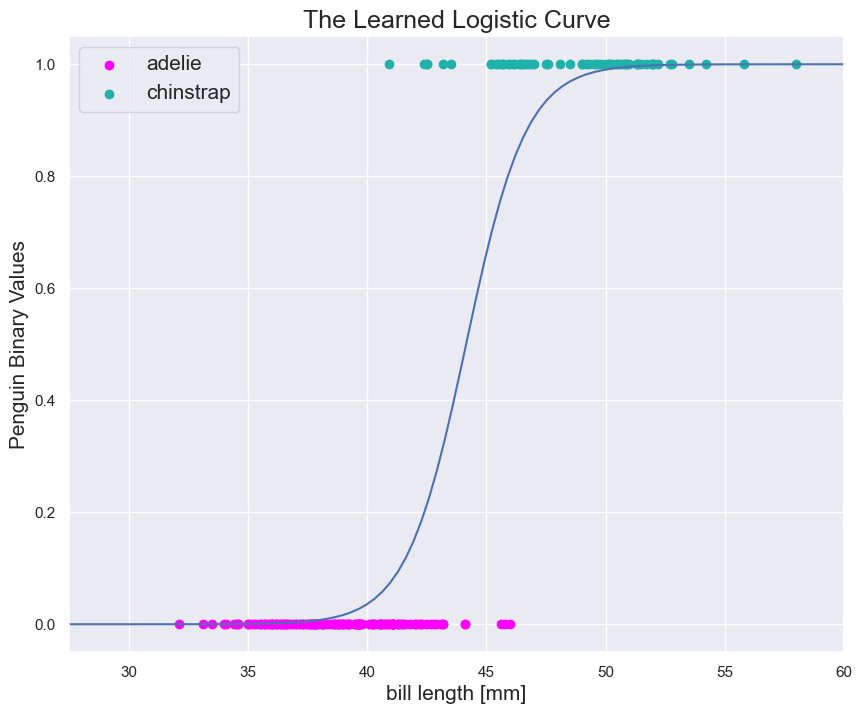

In [139]:
plt.figure(figsize = (10, 8))
plt.xlim((27.5, 60 ))

adelie_len = len(adelie.bill_length_mm)
chinstrap_len = len(chinstrap.bill_length_mm)

plt.scatter(adelie.bill_length_mm, 
            np.zeros(adelie_len), 
            color = "magenta", 
            label = "adelie")
plt.scatter(chinstrap.bill_length_mm, 
            np.ones(chinstrap_len), 
            color = "lightseagreen", 
            label = "chinstrap")

# scaling domain to match scaling in X
domain = np.linspace(27.5, 60, 100).reshape(-1, 1)
domain_scaled = scaler.transform(domain) 

plt.plot(domain, node.predict(domain_scaled))
plt.xlabel("bill length [mm]", fontsize = 15)
plt.ylabel("Penguin Binary Values", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("The Learned Logistic Curve", fontsize = 18)
plt.show()

In [151]:
# shows the probabilities the model assigns to each specimen
print(node.predict(X_scaled))
# shows us how many times the model predicted incorrectly
np.rint(node.predict(X_scaled)) != y

[1.78770264e-02 2.43855863e-02 4.50096010e-02 2.70768655e-03
 2.08845963e-02 1.52958074e-02 1.93235342e-02 3.45469387e-04
 1.53547418e-01 6.45223267e-03 6.45223267e-03 8.16170917e-02
 1.20972492e-02 5.13444570e-04 2.50182329e-03 1.30823197e-02
 2.12379992e-01 4.38191019e-04 8.12174820e-01 6.45223267e-03
 5.96337688e-03 1.43780461e-03 8.83875635e-03 1.41464551e-02
 8.94021443e-04 5.64133797e-02 5.23386044e-02 6.98088162e-03
 5.23386044e-02 2.43855863e-02 4.01960782e-03 2.43855863e-02
 7.04931814e-02 2.13576363e-03 1.93235342e-02 1.41464551e-02
 1.75305577e-01 5.51135398e-03 3.07321530e-02 2.31157537e-03
 6.54719783e-02 1.55625138e-03 4.89466766e-01 3.43223439e-03
 2.63446033e-02 8.16170917e-02 5.09341877e-03 1.55625138e-03
 1.87064073e-01 2.63446033e-02 3.86650091e-02 7.04913687e-04
 1.53547418e-01 4.74328441e-04 1.01311908e-01 1.65369743e-02
 5.64133797e-02 2.31157537e-03 5.51135398e-03 1.22723759e-03
 9.43182492e-02 5.51135398e-03 8.16170917e-02 2.13576363e-03
 1.16688530e-01 1.047475

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [169]:
# rounds probabilities to the nearest integer, showing how the model would classfiy inputs
classification_error = (np.rint(node.predict(X_scaled)) != y).astype(int)

# shows the proportion of missclassifications to the total sample size
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.04090909090909091


---

Another visualization of our model's predictions is the decision boundary plot, which gives the viewer a rough idea of how many of each kind of penguin fall onto the wrong side of the boundary. From the plot, we can see that the main mistake our model has main is classifying Chinstrap penguins (the ones, or orange triangles) as Adelie penguins (the zeros, or blue squares).

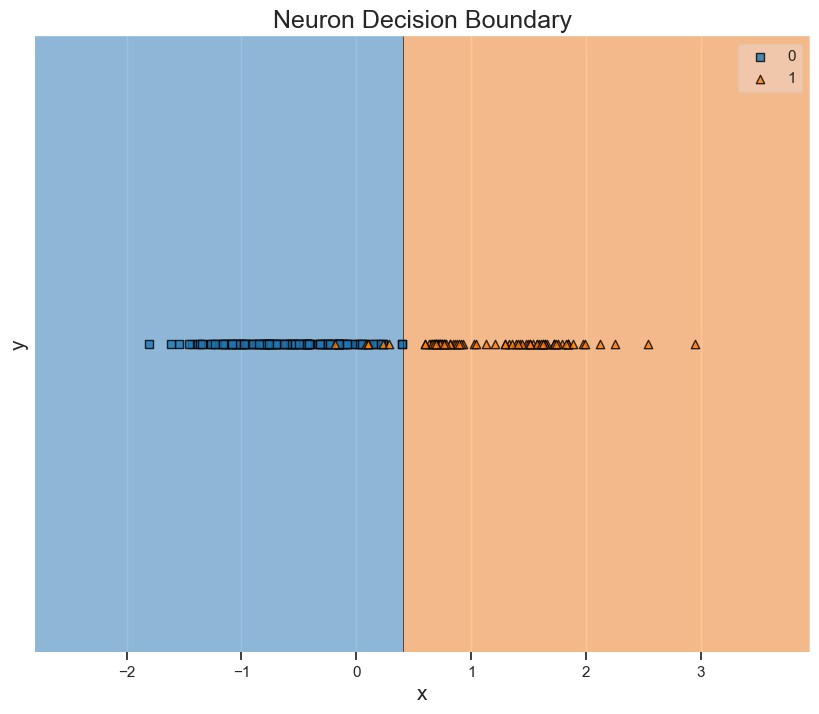

In [138]:
node.plot_decision_boundary(X_scaled, y)

Text(92.25, 0.5, 'True labels')

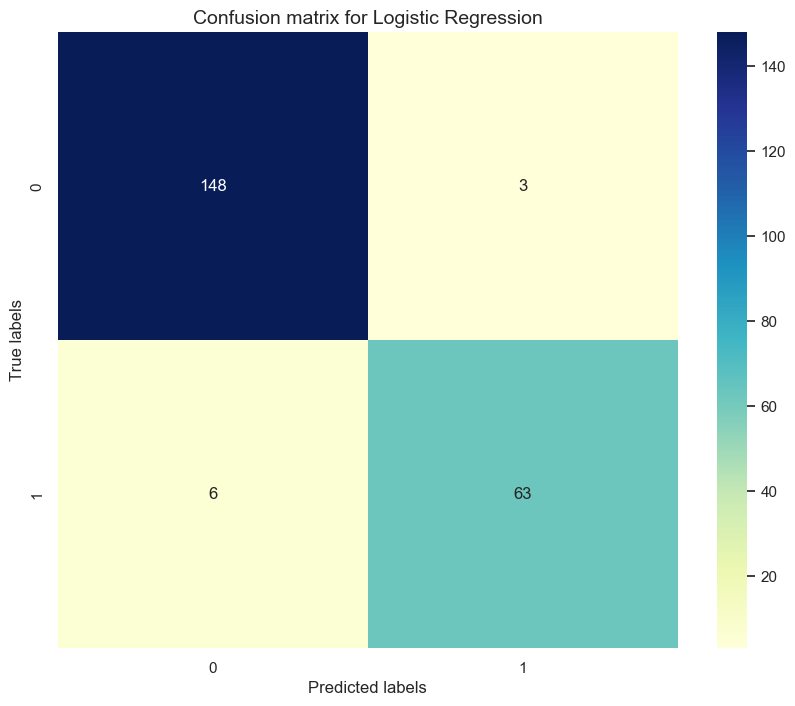

In [166]:
# If y_pred contains probabilities (continuous values between 0 and 1)
# Convert them to binary class labels using a threshold of 0.5
y_pred_classes = (y_pred > 0.5).astype(int)

# Now create the confusion matrix with the class labels
fig = plt.figure(figsize = (10,8))
cm = confusion_matrix(y, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu")
plt.title('Confusion matrix for Logistic Regression', fontsize=14)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

## Part 4: Logistic Regression Single Neuron with Multiple Entries in the Input Vector

We will now add another feature into our logistic model, bill depth (refer to the plots at the beginning of the noteboook), to explore if this extra information could improve the model's predictions. The code will function much the same as before, with only slight changes such as the omission of the ```reshape``` method since our X data will now have two columns. This is possible because stochastic gradient descent, the driving force behind our Neuron class, can optimize over several entries in an input vector simultaneously, although it proceeds through one training example at a time.

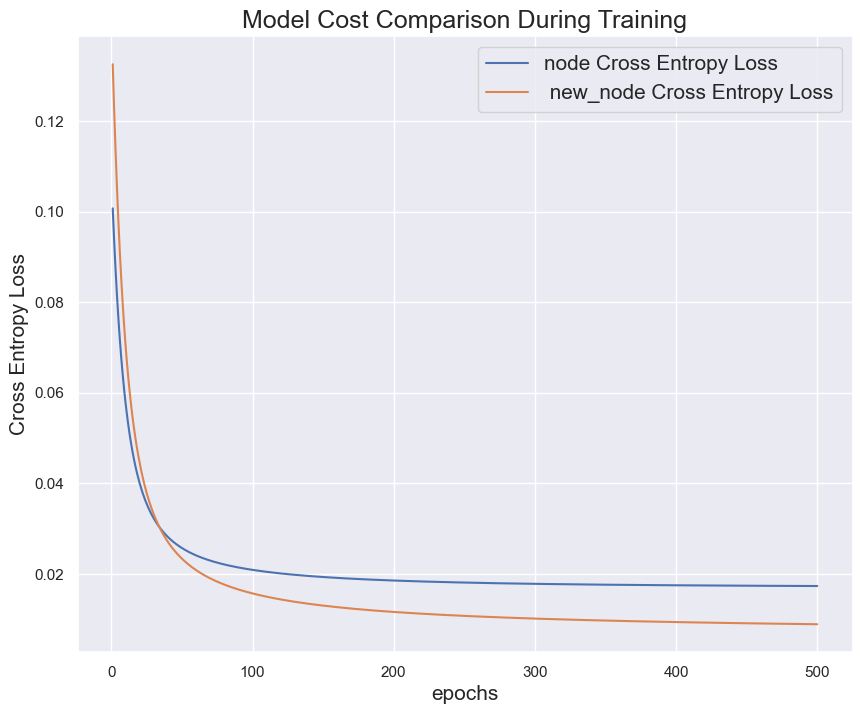

In [156]:
# create new neuron
new_node = Neuron(sigmoid_fn, bin_ent_loss)

# Create a numpy.ndarray of bill length and bill depth values for
# the two species of penguins 
new_X = df.iloc[:220][["bill_length_mm", "bill_depth_mm"]].values

#scale new_X
scaler = StandardScaler()
new_X_scaled = scaler.fit_transform(new_X)


# Train the new single neuron model on the new feature vectors
new_node.fit(new_X_scaled, y, learning_rate = 0.001, epochs = 500)


plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.loss_history_) + 1), 
         node.loss_history_,
         label = "node Cross Entropy Loss")
plt.plot(range(1, len(new_node.loss_history_) + 1), 
         new_node.loss_history_,
         label = " new_node Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)


plt.show()

---
The plot above demonstrates the usefulness of predicting off of two features rather than one. Although the new node begins with greater error, it is eventually able to overtake the previous node, in a sense "learning more" it its 500 epochs than the previous node. Below, we will visualize the decision boundary produced by the new node. Note, the boundary is not a vertical line, but a diagonal one- allowing for more entries in the input vector created a model that is more flexible (i.e., able to optimize in 2 dimensions rather than one).

---

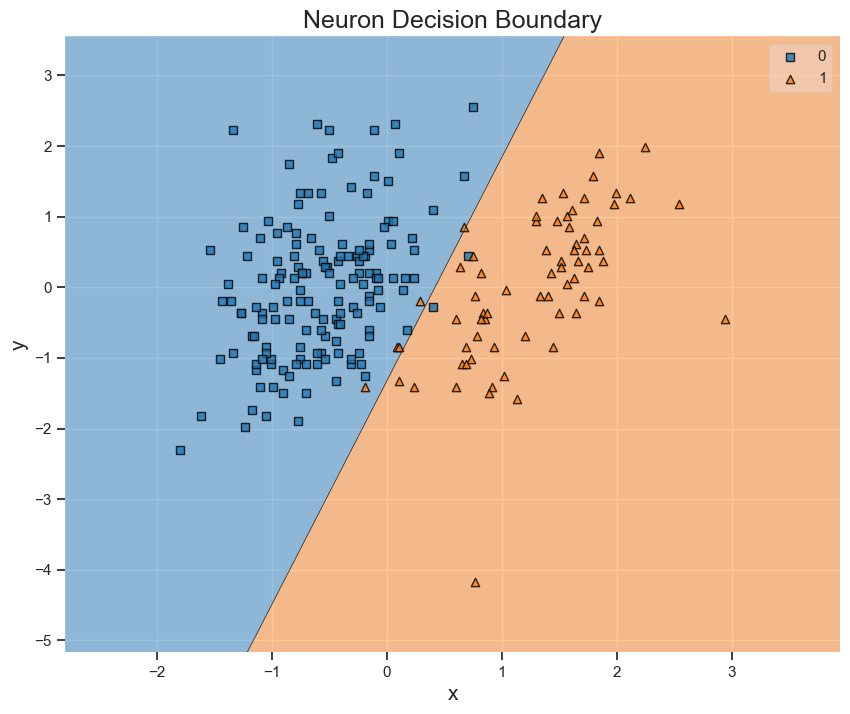

In [157]:
new_node.plot_decision_boundary(new_X_scaled, y)

## Conclusion

- This model was successful in predicting a penguin's species based on its bill length, as evidenced by the Classification Error of 0.041, or 4.1%. We can see from the confusion matrix that out of the 9 misses, most of them were Chinstrap penguins classified as Adelie, which reinforces what the first decision boundary plot illustrated.

- When given an input vector with multiple entries, the model's performance improves. We can see this in the second decision boundary plot, with a reduction in the number of errors.

- Similar to the perceptron, this model is limited by binary classificiation, however it enhances the abilities of the perceptron with its probabilistic predictions.